Date: 05.01.2023 \
Author: Reto Hendry

This notebook was used for the training of CNNs. \
It does not show any usable results since it was still in a try and error phase. 

### Import libraries and load data

In [4]:
import nibabel as nib
import nilearn as nil
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import sys

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, callbacks, initializers
import keras_tuner as kt

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
from functions.function_get_label_df import get_label_df
from functions.function_get_feature_positions import get_feature_positions

In [2]:
# path to data
#  - on Windows: C:/Users/tahendry/Desktop/Masterthesis_Reto/
#  - on Linux:   ../data/

try:
    print(os.uname())
    data_path = "../data/"
except:
    print("Windows")
    data_path = "C:/Users/tahendry/Desktop/Masterthesis_Reto/"

posix.uname_result(sysname='Linux', nodename='dalcowks', release='5.13.0-40-generic', version='#45~20.04.1-Ubuntu SMP Mon Apr 4 09:38:31 UTC 2022', machine='x86_64')


In [7]:
# read in the excel-file with the labels
data_path = "../../data/"
label_file = "Conn_IDs_Matching_90_subjects.xlsx"

# read excel with only the first three columns
# Sham = 1, Verum = 2
df_label = (pd.read_excel(os.path.join(data_path, label_file),
                            usecols=[0, 1, 2])
            .replace({"Cond": {1: 0}})
            .replace({"Cond": {2: 1}})
            )

df_label["Cond"] = df_label["Cond"].astype("category")

label_df = df_label.copy()

label_df.head()

/tmp/ipykernel_4151760/4283937719.py:7: FutureWarning: Defining usecols with out of bounds indices is deprecated and will raise a ParserError in a future version.
  df_label = (pd.read_excel(os.path.join(data_path, label_file),


,Conn_SubjNr,Cond
0,1,1
1,2,1
2,3,1
3,4,0
4,5,1


In [13]:
# read MVPA data
path_content = os.listdir(os.path.join(data_path, "Denoised_MVPA_8mm"))

# make two lists with pre (Condition002) and post (Condition003) data of first component
comp1_pre = sorted([x for x in path_content 
                    if "Component001" in x 
                    and "Condition001" in x])
comp1_post = sorted([x for x in path_content 
                    if "Component001" in x 
                    and "Condition002" in x])

print(comp1_pre[:5])
print(comp1_post[:5])

['BETA_Subject001_Condition001_Measure001_Component001.nii', 'BETA_Subject002_Condition001_Measure001_Component001.nii', 'BETA_Subject003_Condition001_Measure001_Component001.nii', 'BETA_Subject004_Condition001_Measure001_Component001.nii', 'BETA_Subject005_Condition001_Measure001_Component001.nii']
['BETA_Subject001_Condition002_Measure001_Component001.nii', 'BETA_Subject002_Condition002_Measure001_Component001.nii', 'BETA_Subject003_Condition002_Measure001_Component001.nii', 'BETA_Subject004_Condition002_Measure001_Component001.nii', 'BETA_Subject005_Condition002_Measure001_Component001.nii']


### Prepare data for keras

In [15]:
# create a dataset with the difference of pre and post data
comp1_diff = []
for pre, post in zip(comp1_pre, comp1_post):
    pre_vol = nib.load(os.path.join(data_path, "Denoised_MVPA_8mm", pre))
    post_vol = nib.load(os.path.join(data_path, "Denoised_MVPA_8mm", post))
    pre_vol_data = pre_vol.get_fdata()
    post_vol_data = post_vol.get_fdata()
    diff_vol_data = post_vol_data - pre_vol_data
    comp1_diff.append(diff_vol_data)

# check the shape of the data
print(comp1_diff[0].shape)

# check the type of the data
print(type(comp1_diff[0]))

# takes about 4 mins to run on Dell

(91, 109, 91)
<class 'numpy.ndarray'>


In [16]:
# stack the data to later use it as input for the CNN
# note: the first dimension is the number of samples
print(f"shape of one list element before stacking: {comp1_diff[0].shape=}")
inpt_comp1_diff = np.stack(comp1_diff, axis=0)

# expand the dimensions to fit the input shape of the CNN
# note: the last dimension is the number of channels
inpt_comp1_diff = np.expand_dims(inpt_comp1_diff, axis=-1)

# normalize the input data (zero mean, unit variance)
# note: a CNN works best with normalized data
inpt_comp1_diff = (inpt_comp1_diff - inpt_comp1_diff.mean()) / inpt_comp1_diff.std()

print(f"{inpt_comp1_diff.shape=}",
      f"{inpt_comp1_diff.mean()=}",
      f"{inpt_comp1_diff.std()=}", sep="\n")

shape of one list element before stacking: comp1_diff[0].shape=(91, 109, 91)
inpt_comp1_diff.shape=(90, 91, 109, 91, 1)
inpt_comp1_diff.mean()=-2.538993041528751e-16
inpt_comp1_diff.std()=0.999999999999968


In [19]:
# split the data into training and test data
# use 80% of the data for training and 20% for testing
x_train, x_test, y_train, y_test = train_test_split(inpt_comp1_diff, 
                                                    label_df["Cond"], 
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=label_df["Cond"]
                                                    )

# check the shape of the data
print(f"{x_train.shape=}",
        f"{x_test.shape=}",
        f"{y_train.shape=}",
        f"{y_test.shape=}", sep="\n")

# prepare for k-fold cross-validation
# note: StratifiedKFold ensures that the proportion of samples of each class is the same in each fold
nbr_of_folds = 9
kfold = StratifiedKFold(n_splits=nbr_of_folds, shuffle=True, random_state=42)

x_train.shape=(72, 91, 109, 91, 1)
x_test.shape=(18, 91, 109, 91, 1)
y_train.shape=(72,)
y_test.shape=(18,)


### Built some models

#### 3D-CNN

In [20]:
# identical model to the M2DCNN Paper

# built a keras CNN model with functional API
def build_compile_3DCNN(summary=False):

    # layer 1
    inputs = keras.Input(shape=(inpt_comp1_diff.shape[1:]))
    x = layers.Conv3D(filters=16, 
                      kernel_size=3, 
                      strides=1,
                      kernel_initializer=initializers.glorot_normal()) (inputs)
    x = keras.layers.LeakyReLU() (x)
    x = layers.MaxPooling3D(pool_size=2, 
                            strides=2, 
                            padding='valid') (x)
    x = keras.layers.BatchNormalization() (x)

    # layer 2
    x = layers.Conv3D(filters=32, 
                      kernel_size=3, 
                      strides=1,
                      kernel_initializer=initializers.glorot_normal()) (x)
    x = keras.layers.LeakyReLU() (x)
    x = layers.MaxPooling3D(pool_size=2, 
                            strides=2, 
                            padding='valid') (x)
    x = keras.layers.BatchNormalization()  (x)

    # flatten and create dense layer
    x = layers.Flatten() (x)
    x = layers.Dense(units=128,
                     kernel_initializer=initializers.glorot_normal()) (x)
    x = keras.layers.LeakyReLU() (x)
    x = keras.layers.BatchNormalization() (x)
    x = keras.layers.Dropout(0.5) (x)
    outputs = layers.Dense(1, activation="sigmoid") (x)

    # define the model
    model = keras.Model(inputs=inputs, outputs=outputs)

    if summary == True:
        model.summary()

    # compile the model
    my_adam = keras.optimizers.Adam(learning_rate=0.0025, beta_1=0.9, beta_2=0.999, amsgrad=True)
    model.compile(optimizer=my_adam,
                    loss='binary_crossentropy',
                    metrics=[keras.metrics.Accuracy(name="Accuracy")])

    return model

build_compile_3DCNN(summary=True)

2023-05-14 15:19:59.359030: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2023-05-14 15:19:59.481701: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-05-14 15:19:59.484321: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 91, 109, 91, 1)]  0         
                                                                 
 conv3d (Conv3D)             (None, 89, 107, 89, 16)   448       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 89, 107, 89, 16)   0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 44, 53, 44, 16)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 44, 53, 44, 16)   64        
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 42, 51, 42, 32)    13856 

#### s2D-CNN

In [21]:
# identical model to the M2DCNN Paper

# built a keras CNN model with functional API
def build_compile_s2DCNN(summary=False):

    # layer 1
    inputs = keras.Input(shape=(inpt_comp1_diff.shape[1:]))
    x = layers.Conv2D(filters=16, 
                      kernel_size=3, 
                      strides=1,
                      kernel_initializer=initializers.glorot_normal()) (inputs)
    x = keras.layers.LeakyReLU() (x)
    x = layers.MaxPooling2D(pool_size=2, 
                            strides=2, 
                            padding='valid') (x)
    x = keras.layers.BatchNormalization() (x)

    # layer 2
    x = layers.Conv2D(filters=32, 
                      kernel_size=3, 
                      strides=1,
                      kernel_initializer=initializers.glorot_normal()) (x)
    x = keras.layers.LeakyReLU() (x)
    x = layers.MaxPooling2D(pool_size=2, 
                            strides=2, 
                            padding='valid') (x)
    x = keras.layers.BatchNormalization()  (x)

    # flatten and create dense layer
    x = layers.Flatten() (x)
    x = layers.Dense(units=128,
                     kernel_initializer=initializers.glorot_normal()) (x)
    x = keras.layers.LeakyReLU() (x)
    x = keras.layers.BatchNormalization() (x)
    x = keras.layers.Dropout(0.5) (x)
    outputs = layers.Dense(1, activation="sigmoid") (x)

    # define the model
    model = keras.Model(inputs=inputs, outputs=outputs)

    if summary == True:
        model.summary()

    # compile the model
    my_adam = keras.optimizers.Adam(learning_rate=0.0025, beta_1=0.9, beta_2=0.999, amsgrad=True)
    model.compile(optimizer=my_adam,
                    loss='binary_crossentropy',
                    metrics=[keras.metrics.Accuracy(name="Accuracy")])

    return model

build_compile_s2DCNN(summary=True)

ValueError: Input 0 of layer "max_pooling2d" is incompatible with the layer: expected ndim=4, found ndim=5. Full shape received: (None, 91, 107, 89, 16)

#### M2D-CNN

In [22]:
# identical model to the M2DCNN Paper

# built a keras CNN model with functional API
def build_compile_M2DCNN(summary=False):

    DIMX, DIMY, DIMZ = inpt_comp1_diff.shape[1:]

    def up_model(input_tensor):
        # layer 1
        x = layers.Conv2D(filters=16, 
                        kernel_size=3, 
                        strides=1,
                        kernel_initializer=initializers.glorot_normal()) (input_tensor)
        x = layers.LeakyReLU() (x)
        x = layers.MaxPooling2D(pool_size=2, 
                                strides=2, 
                                padding='valid') (x)
        x = layers.BatchNormalization() (x)

        # layer 2
        x = layers.Conv2D(filters=32, 
                        kernel_size=3, 
                        strides=1,
                        kernel_initializer=initializers.glorot_normal()) (x)
        x = layers.LeakyReLU() (x)
        x = layers.MaxPooling2D(pool_size=2, 
                                strides=2, 
                                padding='valid') (x)
        x = layers.BatchNormalization()  (x)

        # flatten and create dense layer
        x = layers.Flatten() (x)
        return x


    def front_model(input_tensor):
        # layer 1
        x = layers.Conv2D(filters=16, 
                        kernel_size=3, 
                        strides=1,
                        kernel_initializer=initializers.glorot_normal()) (input_tensor)
        x = layers.LeakyReLU() (x)
        x = layers.MaxPooling2D(pool_size=2, 
                                strides=2, 
                                padding='valid') (x)
        x = layers.BatchNormalization() (x)

        # layer 2
        x = layers.Conv2D(filters=32, 
                        kernel_size=3, 
                        strides=1,
                        kernel_initializer=initializers.glorot_normal()) (x)
        x = layers.LeakyReLU() (x)
        x = layers.MaxPooling2D(pool_size=2, 
                                strides=2, 
                                padding='valid') (x)
        x = layers.BatchNormalization()  (x)

        # flatten and create dense layer
        x = layers.Flatten() (x)
        return x


    def left_model(input_tensor):
        # layer 1
        x = layers.Conv2D(filters=16, 
                        kernel_size=3, 
                        strides=1,
                        kernel_initializer=initializers.glorot_normal()) (input_tensor)
        x = layers.LeakyReLU() (x)
        x = layers.MaxPooling2D(pool_size=2, 
                                strides=2, 
                                padding='valid') (x)
        x = layers.BatchNormalization() (x)

        # layer 2
        x = layers.Conv2D(filters=32, 
                        kernel_size=3, 
                        strides=1,
                        kernel_initializer=initializers.glorot_normal()) (x)
        x = layers.LeakyReLU() (x)
        x = layers.MaxPooling2D(pool_size=2, 
                                strides=2, 
                                padding='valid') (x)
        x = layers.BatchNormalization()  (x)

        # flatten and create dense layer
        x = layers.Flatten() (x)
        return x

    # NOTE: eventually only works with keras.layers.Input
    up_input = layers.Input(shape=(DIMX, DIMY, DIMZ))
    front_input = layers.Input(shape=(DIMX, DIMZ, DIMY))
    left_input = layers.Input(shape=(DIMY, DIMZ, DIMX))

    up_output = up_model(up_input)
    front_output = front_model(front_input)
    left_output = left_model(left_input)

    # concatenate the outputs of the multichannel model
    merged = layers.Concatenate() ([up_output, front_output, left_output])
    fm = layers.BatchNormalization() (merged)
    fm = layers.Dense(units=128, 
                            kernel_initializer=initializers.glorot_normal()) (fm)
    fm = layers.LeakyReLU() (fm)
    fm = layers.BatchNormalization() (fm)
    fm = layers.Dropout(0.5) (fm)
    outputs = layers.Dense(units=1, activation='sigmoid') (fm)

    # define the model
    model = keras.Model(inputs=[up_input, front_input, left_input], outputs=outputs)

    if summary == True:
        model.summary()
        keras.utils.plot_model(model, "M2DCNN.png", show_shapes=True)

    # compile the model
    my_adam = keras.optimizers.Adam(learning_rate=0.0025, beta_1=0.9, beta_2=0.999, amsgrad=True)
    model.compile(optimizer=my_adam,
                    loss='binary_crossentropy',
                    metrics=[keras.metrics.Accuracy(name="Accuracy")])

    return model

build_compile_M2DCNN(summary=True)

ValueError: too many values to unpack (expected 3)

### cross validation

In [23]:
# callback to stop training when loss does not improve anymore and save the best model
callback_list = [callbacks.EarlyStopping(monitor="val_loss", patience=5),
                 callbacks.ModelCheckpoint(filepath="./MVPA_CNN_model_cv.keras", 
                                            monitor="val_loss",
                                            save_best_only=True)]

# create empty lists to store the results of the k-fold cross-validation
val_loss = []
val_acc = []
history_list = []

# k-fold cross-validation
for fold, (train_idx, test_idx) in enumerate(kfold.split(x_train, y_train)):
    if fold == 0:
        print(f"cross validation started...", 
                f"size of the training data: {len(train_idx)}",
                f"size of the test data: {len(test_idx)}", 
                sep="\n")

    # create the folds
    print(f"Fold {fold+1} of {nbr_of_folds}")
    x_train_fold = x_train[train_idx]
    x_test_fold = x_train[test_idx]
    y_train_fold = y_train.iloc[train_idx]
    y_test_fold = y_train.iloc[test_idx]

    # print shape of the folds
    # print(f"{x_train_fold.shape=}",
    #     f"{x_test_fold.shape=}",
    #     f"{y_train_fold.shape=}",
    #     f"{y_test_fold.shape=}", sep="\n")

    # build and compile the model
    model = build_and_compile_model()

    # train the model
    history = model.fit(x_train_fold, y_train_fold,
                        epochs=20,
                        batch_size=4,
                        validation_data=(x_test_fold, y_test_fold),
                        callbacks=callback_list,
                        verbose=1)
    history_list.append(history)

    # evaluate the model
    fold_loss = model.evaluate(x_test_fold, y_test_fold, verbose=0)[0]
    fold_acc = model.evaluate(x_test_fold, y_test_fold, verbose=0)[1]
    val_loss.append(fold_loss)
    val_acc.append(fold_acc)
    print(f"Loss: {fold_loss}", f"Accuracy: {fold_acc}", sep="\n")

# print the mean of the validation loss and accuracy
print(f"Mean validation loss: {np.mean(val_loss)}",
        f"Mean validation accuracy: {np.mean(val_acc)}", sep="\n")
        
# save the model
# model.save("X:/MasterThesis_Reto/3d_cnn_model")

cross validation started...
size of the training data: 64
size of the test data: 8
Fold 1 of 9


NameError: name 'build_and_compile_model' is not defined

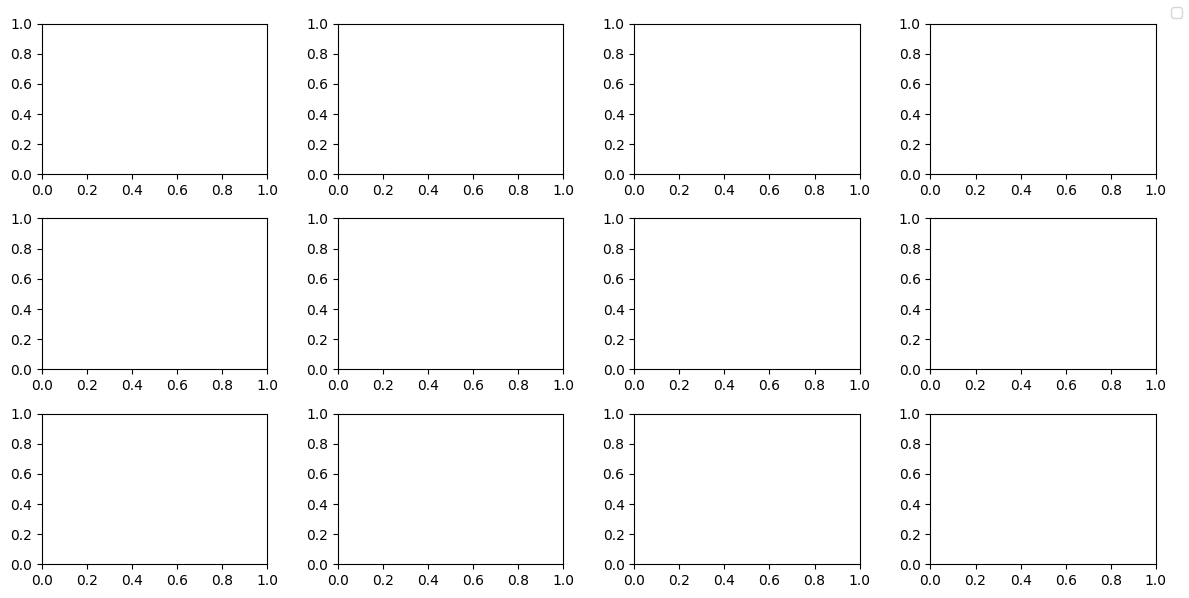

In [24]:
# create subplot to show all folds from cross-validation
fig, axs = plt.subplots(3, 4, figsize=(12, 6))
axs = axs.ravel()
for i, history in enumerate(history_list):
    axs[i].plot(history.history["loss"][1:])
    axs[i].plot(history.history["val_loss"][1:])
    axs[i].plot(history.history["Accuracy"][1:])
    axs[i].plot(history.history["val_Accuracy"][1:])
    axs[i].set_title(f"Fold {i+1}")
    axs[i].set_ylabel("loss")
    axs[i].set_xlabel("epoch")
    axs[i].grid()

fig.tight_layout()
fig.legend(["loss", "val_loss", "accuracy", "val_Accuracy"])


### train and evaluate model with the entire test data (no val. data)

#### 3D-CNN

In [45]:
# train with entire training data (no validation data)
# callback to stop training when loss does not improve anymore and save the best model
early_stop = callbacks.EarlyStopping(monitor="loss", patience=6, mode="auto")
checkpoint = callbacks.ModelCheckpoint(filepath="./3DCNN.keras", 
                                        monitor="val_Accuracy",
                                        save_best_only=True, mode="max",
                                        verbose=1)
callback_list = [early_stop, checkpoint]

# build and compile the model
model = build_compile_3DCNN()

# train the model
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=4,
                    callbacks=callback_list,
                    verbose=1,
                    validation_data=(x_test, y_test))


Epoch 1/10
14/14 [==============================] - ETA: 0s - loss: 1.3696 - Accuracy: 0.0000e+00
Epoch 1: val_Accuracy improved from -inf to 0.14286, saving model to ./3DCNN.keras
14/14 [==============================] - 8s 491ms/step - loss: 1.3696 - Accuracy: 0.0000e+00 - val_loss: 4.6870 - val_Accuracy: 0.1429
Epoch 2/10
14/14 [==============================] - ETA: 0s - loss: 0.9819 - Accuracy: 0.0000e+00
Epoch 2: val_Accuracy did not improve from 0.14286
14/14 [==============================] - 5s 340ms/step - loss: 0.9819 - Accuracy: 0.0000e+00 - val_loss: 1.9125 - val_Accuracy: 0.0714
Epoch 3/10
14/14 [==============================] - ETA: 0s - loss: 0.6956 - Accuracy: 0.0000e+00
Epoch 3: val_Accuracy did not improve from 0.14286
14/14 [==============================] - 5s 344ms/step - loss: 0.6956 - Accuracy: 0.0000e+00 - val_loss: 0.9242 - val_Accuracy: 0.0000e+00
Epoch 4/10
14/14 [==============================] - ETA: 0s - loss: 0.4499 - Accuracy: 0.0000e+00
Epoch 4: val_A

1/1 [==============================] - 0s 386ms/step - loss: 4.6870 - Accuracy: 0.1429


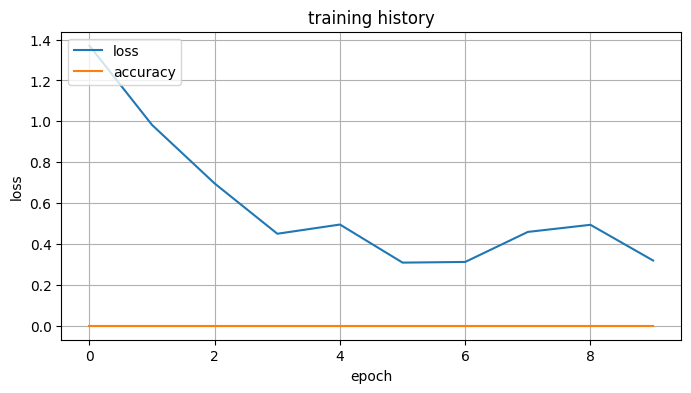

In [46]:
# load the best model
model = keras.models.load_model("./3DCNN.keras")

# evaluate the model
model.evaluate(x_test, y_test, verbose=1)

# plot the training history
fig = plt.figure(figsize=(8, 4))
plt.plot(history.history["loss"])
# plt.plot(history.history["val_loss"])
plt.plot(history.history["Accuracy"])
# plt.plot(history.history["val_Accuracy"])
plt.title("training history")
plt.ylabel("loss")
plt.xlabel("epoch")
# plt.legend(["loss", "val_loss", "accuracy", "val_Accuracy"], loc="upper left")
plt.legend(["loss", "accuracy"], loc="upper left")
plt.grid()
plt.show()

#### s2D-CNN

In [30]:
# train with entire training data (no validation data)
# callback to stop training when loss does not improve anymore and save the best model
early_stop = callbacks.EarlyStopping(monitor="loss", patience=6, mode="auto")
checkpoint = callbacks.ModelCheckpoint(filepath="./s2DCNN.keras", 
                                        monitor="val_Accuracy",
                                        save_best_only=True,
                                        mode="auto",
                                        verbose=1)
callback_list = [early_stop, checkpoint]

# build and compile the model
model = build_compile_s2DCNN()

# train the model
history = model.fit(x_train, y_train,
                    epochs=50,
                    batch_size=4,
                    callbacks=callback_list,
                    verbose=2)


Epoch 1/50
14/14 - 1s - loss: 2.1635 - Accuracy: 0.0000e+00 - 1s/epoch - 106ms/step
Epoch 2/50
14/14 - 0s - loss: 0.7435 - Accuracy: 0.0000e+00 - 378ms/epoch - 27ms/step
Epoch 3/50
14/14 - 0s - loss: 0.5065 - Accuracy: 0.0000e+00 - 300ms/epoch - 21ms/step
Epoch 4/50
14/14 - 0s - loss: 0.4357 - Accuracy: 0.0000e+00 - 299ms/epoch - 21ms/step
Epoch 5/50
14/14 - 0s - loss: 0.5221 - Accuracy: 0.0000e+00 - 295ms/epoch - 21ms/step
Epoch 6/50
14/14 - 0s - loss: 0.3135 - Accuracy: 0.0000e+00 - 297ms/epoch - 21ms/step
Epoch 7/50
14/14 - 0s - loss: 0.2857 - Accuracy: 0.0000e+00 - 277ms/epoch - 20ms/step
Epoch 8/50
14/14 - 0s - loss: 0.4259 - Accuracy: 0.0000e+00 - 280ms/epoch - 20ms/step
Epoch 9/50
14/14 - 0s - loss: 0.3021 - Accuracy: 0.0000e+00 - 285ms/epoch - 20ms/step
Epoch 10/50
14/14 - 0s - loss: 0.1978 - Accuracy: 0.0000e+00 - 293ms/epoch - 21ms/step
Epoch 11/50
14/14 - 0s - loss: 0.2723 - Accuracy: 0.0000e+00 - 321ms/epoch - 23ms/step
Epoch 12/50
14/14 - 0s - loss: 0.2286 - Accuracy: 0.00

1/1 [==============================] - 0s 159ms/step - loss: 2.5160 - Accuracy: 0.0000e+00


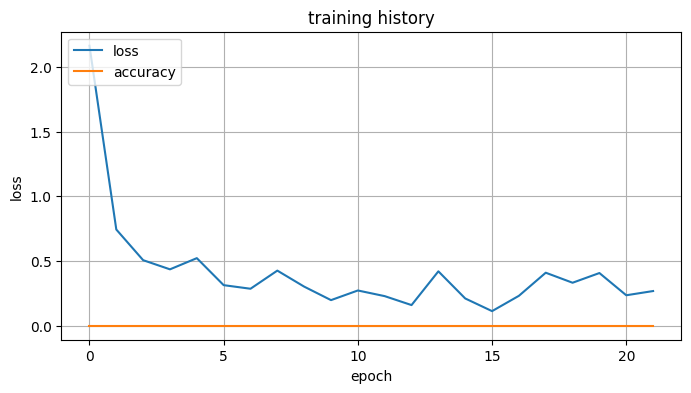

In [31]:
# load the best model
# model = keras.models.load_model("./s2DCNN.keras")

# evaluate the model
model.evaluate(x_test, y_test, verbose=1)

# plot the training history
fig = plt.figure(figsize=(8, 4))
plt.plot(history.history["loss"])
# plt.plot(history.history["val_loss"])
plt.plot(history.history["Accuracy"])
# plt.plot(history.history["val_Accuracy"])
plt.title("training history")
plt.ylabel("loss")
plt.xlabel("epoch")
# plt.legend(["loss", "val_loss", "accuracy", "val_Accuracy"], loc="upper left")
plt.legend(["loss", "accuracy"], loc="upper left")
plt.grid()
plt.show()

### hyperparameter tuning

In [ ]:
# create a function to build and compile the model for hyperparameter tuning

def build_and_compile_model_test(hp):
    """
    Builds model and sets up hyperparameter space to search. Model is compiled.
    
    Parameters
    ----------
    hp : HyperParameter object
        Configures hyperparameters to tune.
        
    Returns
    -------
    model : model
        Compiled keras model with hyperparameters to tune.
    """
    inputs = keras.Input(shape=(inpt_comp1_diff.shape[1:]))
    
    # Tune the number of hidden CNN layers (pair of Conv3D and MaxPool) and filters + kernel_size in each hidden layer.
    # Number of hidden layers: 1 - 5
    # Number of filters: 16 - 512 with stepsize of 32
    # Kernel size: 3 - 5 with stepsize of 2
        
    x = keras.layers.Conv3D(
        filters=hp.Int("filters", min_value=16, max_value=512, step=32),
        kernel_size=3,
        activation="relu", 
        padding="same")(inputs)

    x = keras.layers.MaxPooling3D(pool_size=(2, 2, 2))(x)
    
    # Flatten the output of the last hidden layer
    x = keras.layers.Flatten()(x)

    # Tune the number and units in the dense layer including dropout
    # Number of dense layers: 1 - 3
    # Number of units: 16 - 512 with stepsize of 32
    x = keras.layers.Dense(units=64,
                            activation="relu")(x)

    # Add output layer
    outputs = keras.layers.Dense(1, activation="sigmoid")(x)
    # TODO: maybe try with a softmax activation function

    # define the model
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    # Define optimizer, loss, and metrics
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=["Accuracy"])
    
    return model

In [ ]:
# create a function to build and compile the model for hyperparameter tuning

def build_and_compile_model(hp):
    """
    Builds model and sets up hyperparameter space to search. Model is compiled.
    
    Parameters
    ----------
    hp : HyperParameter object
        Configures hyperparameters to tune.
        
    Returns
    -------
    model : model
        Compiled keras model with hyperparameters to tune.
    """
    inputs = keras.Input(shape=(inpt_comp1_diff.shape[1:]))
    
    # Tune the number of hidden CNN layers (pair of Conv3D and MaxPool) and filters + kernel_size in each hidden layer.
    # Number of hidden layers: 1 - 5
    # Number of filters: 16 - 512 with stepsize of 32
    # Kernel size: 3 - 5 with stepsize of 2
    for i in range(1, hp.Int("num_layers", 2, 6)):
        
        x = keras.layers.Conv3D(
            filters=hp.Int("filters_" + str(i), min_value=16, max_value=512, step=32),
            kernel_size=hp.Int("kernel_size_" + str(i), min_value=3, max_value=5, step=2),
            # kernel_regularizer=hp.Float("l2_regularization_" + str(i), min_value=0.0001, max_value=0.01, step=0.0001),
            activation="relu", 
            padding="same")(inputs)

        x = keras.layers.MaxPooling3D(pool_size=(2, 2, 2))(x)

        # tune dropout layer with values from 0 - 0.3 with stepsize of 0.1
        x = keras.layers.Dropout(hp.Float("dropout_" + str(i), 
                                    min_value=0, max_value=0.3, step=0.1))(x)
    
    # Flatten the output of the last hidden layer
    x = keras.layers.Flatten()(x)

    # Tune the number and units in the dense layer including dropout
    # Number of dense layers: 1 - 3
    # Number of units: 16 - 512 with stepsize of 32
    for i in range(1, hp.Int("num_dense_layers", 2, 4)):
        x = keras.layers.Dense(units=hp.Int("units_" + str(i), min_value=16, max_value=512, step=32),
                               activation="relu")(x)
        
        # tune dropout layer with values from 0 - 0.3 with stepsize of 0.1
        x = keras.layers.Dropout(hp.Float("dense_dropout_" + str(i), 
                                    min_value=0, max_value=0.3, step=0.1))(x)

    # Add output layer
    outputs = keras.layers.Dense(1, activation="sigmoid")(x)
    # TODO: maybe try with a softmax activation function

    # define the model
    model = keras.Model(inputs=inputs, outputs=outputs)

    # Tune learning rate for Adam optimizer with values from 0.01, 0.001, or 0.00001
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-5])
    
    # Define optimizer, loss, and metrics
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=["Accuracy"])
    
    return model

In [ ]:
# Instantiate the tuner
tuner = kt.BayesianOptimization(build_and_compile_model_test,
                                objective="val_Accuracy",
                                max_trials=10,
                                executions_per_trial=2,
                                directory="kt_dir",
                                project_name="kt_BayesianOptimization",
                                overwrite=True)

# Display search space summary
tuner.search_space_summary()

In [ ]:
# start the search for the best hyperparameters

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_Accuracy', patience=5)

tuner.search(x_train, y_train, 
                epochs=20, 
                batch_size=4,
                validation_data=(x_test, y_test),
                callbacks=[stop_early], 
                verbose=2)

In [ ]:
# Get the optimal hyperparameters from the results
best_hps = tuner.get_best_hyperparameters()[0]

# Build model
h_model = tuner.hypermodel.build(best_hps)

# Train the hypertuned model
h_model.fit(x_train, y_train, epochs=20, validation_split=0.2, callbacks=[stop_early], verbose=2)

# Evaluate model on test set
h_model.evaluate(x_test, y_test)


In [ ]:
best_hps = tuner.get_best_hyperparameters()
best_hps

In [ ]:
# train with entire training data (no validation data)
# callback to stop training when loss does not improve anymore and save the best model
callback_list = [callbacks.EarlyStopping(monitor="loss", patience=5),
                 callbacks.ModelCheckpoint(filepath="./MVPA_CNN_model.keras", 
                                            monitor="loss",
                                            save_best_only=True)]

# build and compile the model
model = build_and_compile_model()

# train the model
history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=4,
                    callbacks=callback_list,
                    verbose=1)